In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import uproot
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns


In [2]:
# path to root files
file_path1 = "C:\\Users\\ankit\\Downloads\\Bkg_DstarToD0Pi.root"
file_path2 = "C:\\Users\\ankit\\Downloads\\Prompt_DstarToD0Pi.root"
file_path3 = "C:\\Users\\ankit\\Downloads\\Nonprompt_DstarToD0Pi.root"
name1='bkg'
name2='prompt'
name3='nonprompt'

#initialized separate file objects for each path
f1 = uproot.open(file_path1)
f2 = uproot.open(file_path2)
f3 = uproot.open(file_path3)

topo_vars = [
    "fCpaD0",
    "fCpaXYD0",
    "fDecayLengthXYD0",
    "fImpactParameterProductD0",
    "fImpParamSoftPi",
    "fMaxNormalisedDeltaIPD0"
]

kin_vars = [
    "fPt",
    "fM",
    "fMD0",
    "fInvDeltaMass"
]

para=topo_vars+kin_vars

In [3]:
#extracted tress from each root file
tree1=f1['treeMLDstar']
tree2=f2['treeMLDstar']
tree3=f3['treeMLDstar']

#converting into pandas data frame
branches1=tree1.arrays(topo_vars + kin_vars, library="pd")
branches2=tree2.arrays(topo_vars + kin_vars, library="pd")
branches3=tree3.arrays(topo_vars + kin_vars, library="pd")

In [4]:
#labelling for bkg:0,prompt:1,nonprompt:2
branches1['label']=0
branches2['label']=1
branches3['label']=2

#combining into one single dataframe
df=pd.concat((branches1,branches2,branches3),ignore_index=True)


In [5]:
df

,fCpaD0,fCpaXYD0,fDecayLengthXYD0,fImpactParameterProductD0,fImpParamSoftPi,fMaxNormalisedDeltaIPD0,fPt,fM,fMD0,fInvDeltaMass,label
0,0.824643,0.890379,0.015643,0.000010,-0.002355,2.690436,1.190344,2.105395,1.938962,0.166433,0
1,0.917777,0.905826,0.226232,-0.000314,0.001739,35.127995,2.107522,2.045358,1.887015,0.158342,0
2,0.808133,0.738674,0.007805,0.000013,0.009605,2.846718,2.476917,1.945077,1.788784,0.156293,0
3,0.919379,0.945997,0.012752,0.000001,-0.020536,-1.981847,1.451029,2.021622,1.857827,0.163795,0
4,0.955172,0.950172,0.015169,0.000009,-0.013208,1.605553,1.048973,1.979299,1.810297,0.169002,0
...,...,...,...,...,...,...,...,...,...,...,...
12949171,0.903348,0.877067,0.113936,-0.007914,0.066315,23.384722,2.221442,1.956816,1.811084,0.145732,2
12949172,0.977672,0.998886,0.131194,-0.000119,-0.001408,-3.520980,6.503151,2.052268,1.906304,0.145964,2
12949173,0.984641,0.999750,0.127020,-0.000191,0.007611,1.940192,6.503151,2.052268,1.906304,0.145964,2
12949174,0.995131,0.998502,0.183420,-0.000500,-0.000630,-6.890943,7.495261,2.022863,1.877311,0.145552,2


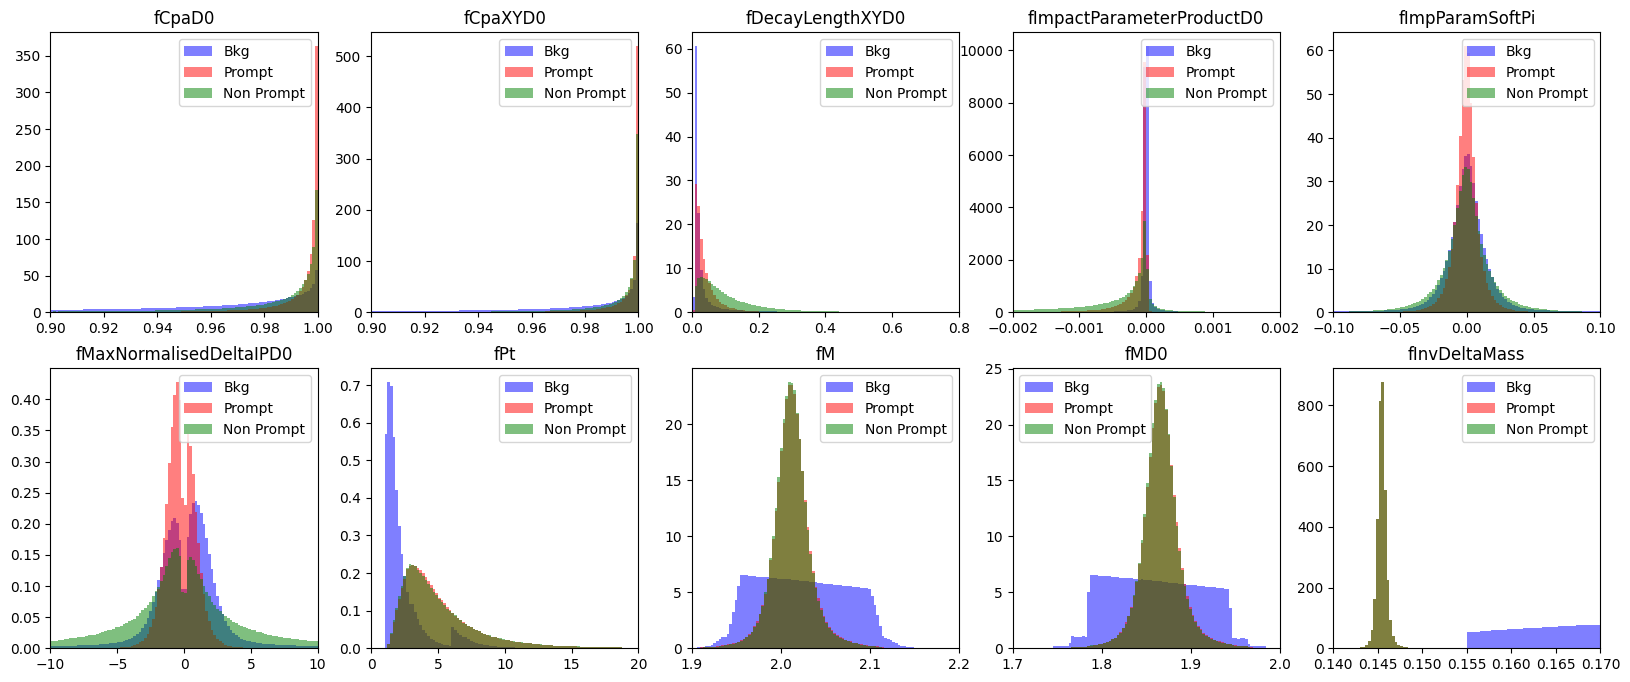

In [6]:

#plotting histograms for Topological and Kinematic parameters for provided datdset

fig,axs=plt.subplots(2,5,figsize=(20,8))
axs=axs.flatten()
xlims = {
    "fCpaD0": (0.9, 1.0),
    "fCpaXYD0": (0.9, 1.0),
    "fDecayLengthXYD0": (0, 0.8),
    "fImpactParameterProductD0": (-0.002, 0.002),
    "fImpParamSoftPi" : (-0.1,0.1),
    "fMaxNormalisedDeltaIPD0" : (-10,10),
    "fPt": (0, 20),
    "fM": (1.9, 2.2),
    "fMD0": (1.7, 2.0),
    "fInvDeltaMass" : (0.14,0.17)
}

for i in range(10):
    
    #bins = common_bins(branches1[para[i]],branches2[para[i]],branches3[para[i]])
    #bins=300
    bins=np.linspace(xlims[para[i]][0],xlims[para[i]][1],101)
    axs[i].hist(branches1[para[i]],bins=bins,alpha=0.5,color='blue',label='Bkg',density=True)
    axs[i].hist(branches2[para[i]],bins=bins,alpha=0.5,color='red',label='Prompt',density=True)
    axs[i].hist(branches3[para[i]],bins=bins,alpha=0.5,color='green',label="Non Prompt",density=True)
    axs[i].set_title(para[i])
    axs[i].set_xlim(xlims.get(para[i], None))
    axs[i].legend()
plt.show()

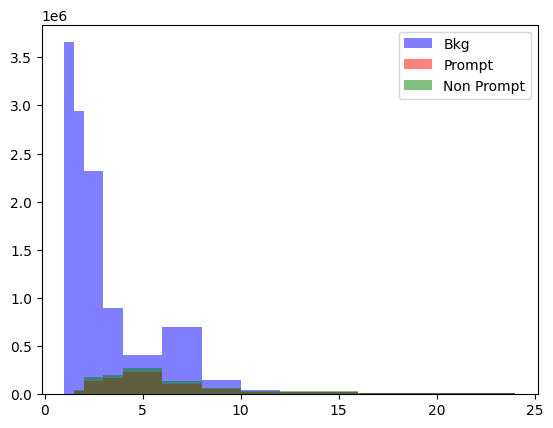

In [7]:
bins=[1, 1.5, 2, 3, 4, 6, 8, 10, 12, 16, 24]
plt.hist(branches1["fPt"],alpha=0.5,bins=bins,color='blue',label='Bkg',density=False)
plt.hist(branches2["fPt"],alpha=0.5,bins=bins,color='red',label='Prompt',density=False)
plt.hist(branches3["fPt"],alpha=0.5,bins=bins,color='green',label="Non Prompt",density=False)
plt.legend()
plt.show()


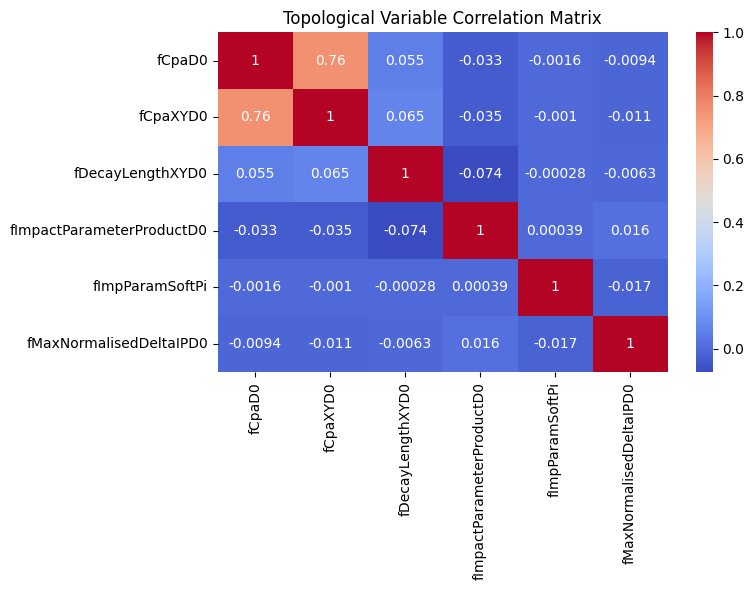

In [8]:
#plotting correlation matrix

corr = df[topo_vars].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Topological Variable Correlation Matrix")
plt.tight_layout()
plt.savefig("correlation_matrix.png", dpi=300)
plt.show()


In [9]:
#separating data with "fPt" between 4 and 6

pt_min, pt_max =4,6

data = df[(df['fPt'] >= pt_min) & (df['fPt'] < pt_max)]

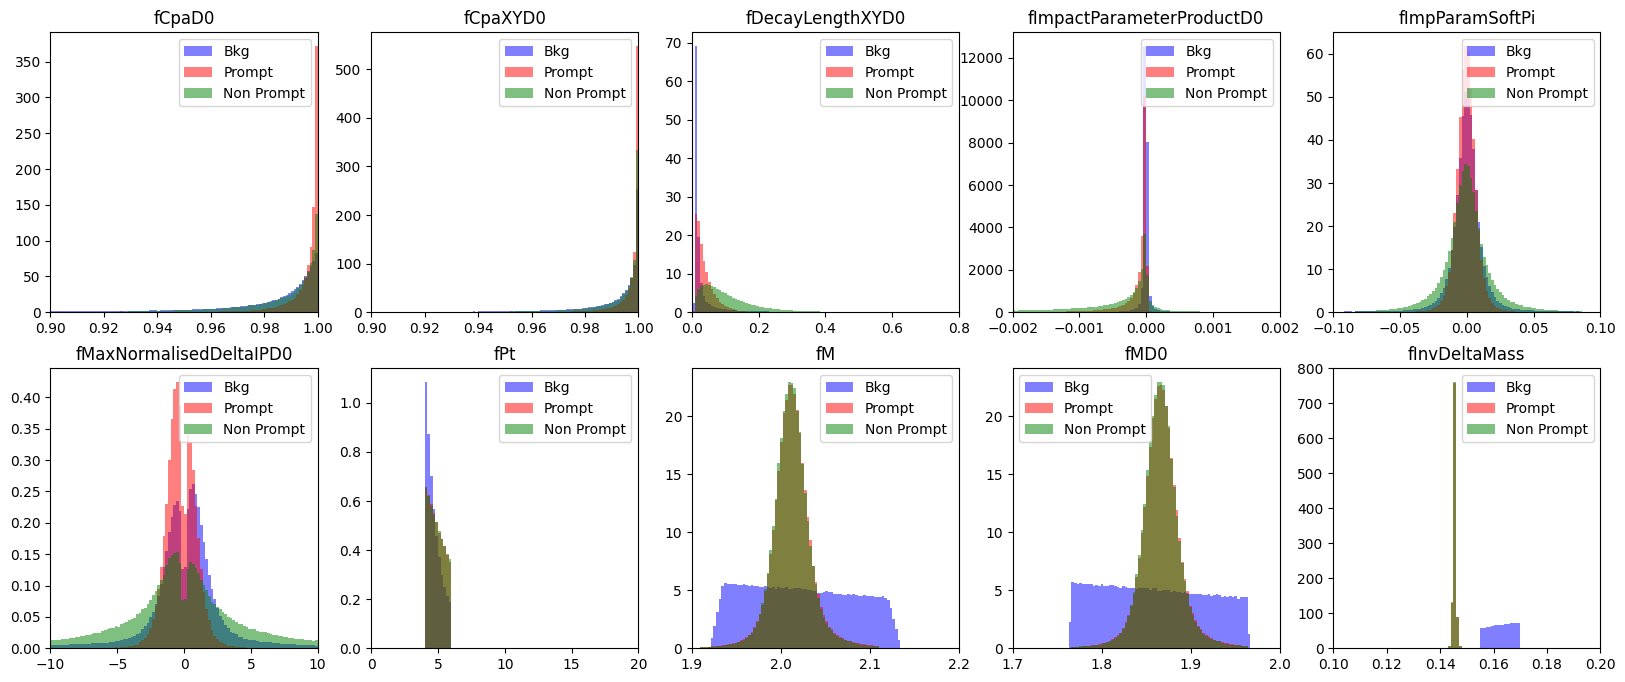

In [10]:
#plotting histograms for Topological and Kinematic parameters for provided [4,6]binned dataset

fig,axs=plt.subplots(2,5,figsize=(20,8))
axs=axs.flatten()
xlims = {
    "fCpaD0": (0.9, 1.0),
    "fCpaXYD0": (0.9, 1.0),
    "fDecayLengthXYD0": (0, 0.8),
    "fImpactParameterProductD0": (-0.002, 0.002),
    "fImpParamSoftPi" : (-0.1,0.1),
    "fMaxNormalisedDeltaIPD0" : (-10,10),
    "fPt": (0, 20),
    "fM": (1.9, 2.2),
    "fMD0": (1.7, 2.0),
    "fInvDeltaMass" : (0.1,0.20)
}
for i in range(10):
    #bins = common_bins(data[data['label']==0][para[i]],data[data['label']==1][para[i]],data[data['label']==2][para[i]])
    #bins=20
    bins=np.linspace(xlims[para[i]][0],xlims[para[i]][1],101)
    axs[i].hist(data[data['label']==0][para[i]],bins=bins,alpha=0.5,color='blue',label='Bkg',density=True)
    axs[i].hist(data[data['label']==1][para[i]],bins=bins,alpha=0.5,color='red',label='Prompt',density=True)
    axs[i].hist(data[data['label']==2][para[i]],bins=bins,alpha=0.5,color='green',label="Non Prompt",density=True)
    axs[i].set_title(para[i])
    axs[i].set_xlim(xlims.get(para[i], None))
    axs[i].legend()
plt.show()

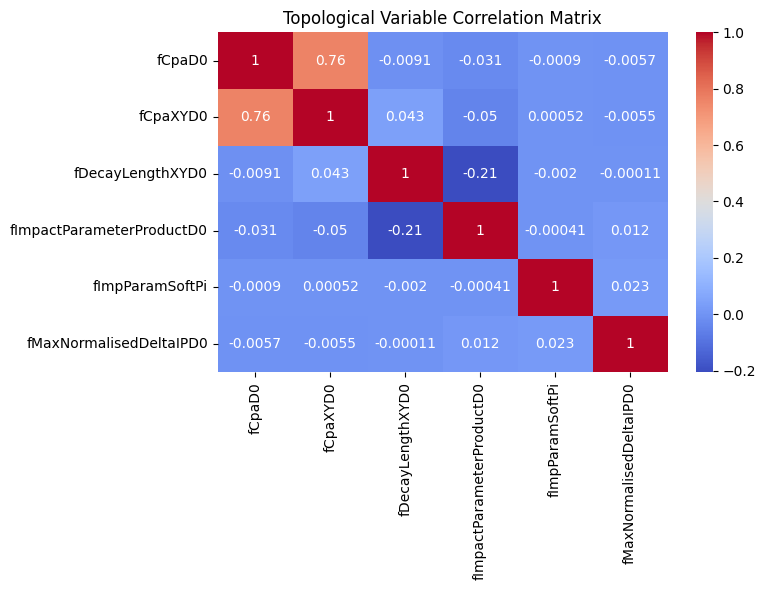

In [11]:
corr = data[topo_vars].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Topological Variable Correlation Matrix")
plt.tight_layout()
plt.savefig("correlation_matrix.png", dpi=300)
plt.show()


In [12]:
#splitting binned dataset into training and testing set

train,test = train_test_split(
    data,
    test_size=0.3,
    stratify=(data["label"]),
    random_state=42
)
X_train=train[topo_vars]
y_train=train['label']
X_test=test[topo_vars]
y_test=test['label']


Validation Accuracy: 0.7872

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.88      0.85    122552
           1       0.65      0.67      0.66     68024
           2       0.85      0.74      0.79     81272

    accuracy                           0.79    271848
   macro avg       0.78      0.76      0.77    271848
weighted avg       0.79      0.79      0.79    271848


Confusion Matrix:
 [[108359   9523   4670]
 [ 16556  45824   5644]
 [  6607  14836  59829]]


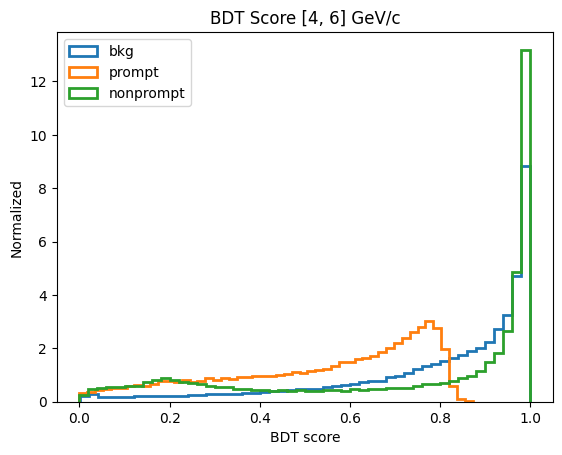

In [13]:
#Implementing XGboost method with default hyperparameters

model = XGBClassifier(random_state=42)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

val_accuracy = accuracy_score(y_test, y_pred)
print(f"Validation Accuracy: {val_accuracy:.4f}")

# classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

#plotting BDT Scores
scores= model.predict_proba(X_test)
plt.hist(scores[y_test==0 , 0],bins=50,density=True,histtype="step",linewidth=2,label="bkg")
plt.hist(scores[y_test==1 , 1],bins=50,density=True,histtype="step",linewidth=2,label="prompt")
plt.hist(scores[y_test==2 , 2],bins=50,density=True,histtype="step",linewidth=2,label="nonprompt")
plt.title(f"BDT Score [{pt_min}, {pt_max}] GeV/c")
plt.xlabel("BDT score")
plt.ylabel("Normalized")
plt.legend()
plt.show()


array([0.19179988, 0.03634176, 0.32131267, 0.28159574, 0.08310233,
       0.08584757], dtype=float32)

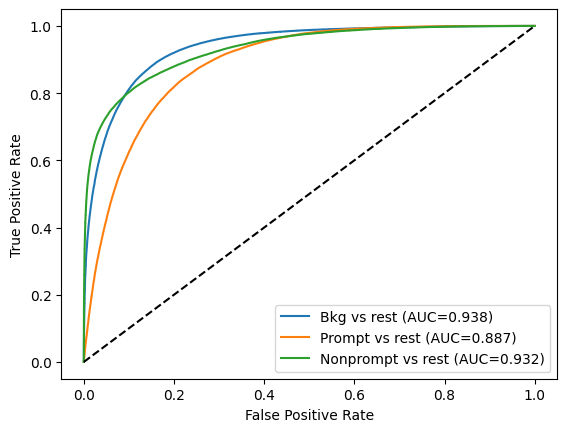

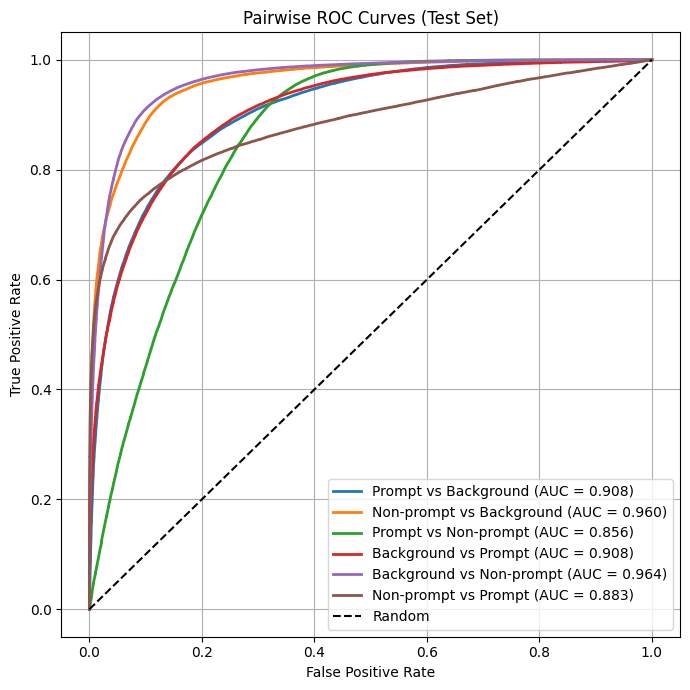

In [14]:
#plotting ROC curves

for k, name in zip([0,1,2], ["Bkg","Prompt","Nonprompt"]):
    y_true = (y_test == k).astype(int)
    y_score = scores[:, k]

    fpr, tpr, _ = roc_curve(y_true, y_score)
    plt.plot(fpr, tpr, label=f"{name} vs rest (AUC={auc(fpr,tpr):.3f})")

plt.plot([0,1],[0,1],"k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

#function to plot pairwise roc
def pairwise_roc(y_true, y_proba, class_sig, class_bkg, label):
    """
    y_true  : true labels
    y_proba : predict_proba output
    class_sig : signal class label
    class_bkg : background class label
    label : legend label
    """

    mask = (y_true == class_sig) | (y_true == class_bkg)

    y_bin = (y_true[mask] == class_sig).astype(int)
    score = y_proba[mask, class_sig]

    fpr, tpr, _ = roc_curve(y_bin, score)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, lw=2,
             label=f"{label} (AUC = {roc_auc:.3f})")
plt.figure(figsize=(7,7))

y_proba=scores
pairwise_roc(y_test, y_proba, 1, 0, "Prompt vs Background")
pairwise_roc(y_test, y_proba, 2, 0, "Non-prompt vs Background")
pairwise_roc(y_test, y_proba, 1, 2, "Prompt vs Non-prompt")
pairwise_roc(y_test, y_proba, 0, 1, "Background vs Prompt")
pairwise_roc(y_test, y_proba, 0, 2, "Background vs Non-prompt")
pairwise_roc(y_test, y_proba, 2, 1, "Non-prompt vs Prompt")

plt.plot([0,1], [0,1], "k--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Pairwise ROC Curves (Test Set)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:
#hyperparameter set for fine tuning
param_grid = {
    "max_depth":         [2, 4],
    "learning_rate":    [0.03, 0.1],
    "n_estimators":     [200, 400],
    "subsample":        [0.7, 0.8],
    "colsample_bynode": [0.7, 1.0],
    "min_child_weight": [3, 7],
    "colsample_bytree": [0.7, 1.0],
    "reg_alpha":        [0.01, 1.0],
    "reg_lambda":       [0,0.5],
    "gamma":            [0, 1.0],
}



In [18]:
#Implementing Randomized Search
xgb_model = XGBClassifier(random_state=42)

grid_search = RandomizedSearchCV(xgb_model, param_grid, cv=8, scoring="roc_auc_ovr", n_iter=5, n_jobs=-1, verbose=2, random_state=42)
grid_search.fit(X_train, y_train)

best_xgb = grid_search.best_estimator_

# Best parameters from tuning
print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

Fitting 8 folds for each of 5 candidates, totalling 40 fits
Best Parameters: {'subsample': 0.7, 'reg_lambda': 0.5, 'reg_alpha': 0.01, 'n_estimators': 400, 'min_child_weight': 3, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 1.0, 'colsample_bynode': 0.7}
Best Accuracy: 0.9167884608219175


Validation Accuracy: 0.7839

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.88      0.85    122552
           1       0.65      0.67      0.66     68024
           2       0.85      0.74      0.79     81272

    accuracy                           0.78    271848
   macro avg       0.77      0.76      0.77    271848
weighted avg       0.79      0.78      0.78    271848


Confusion Matrix:
 [[108008   9599   4945]
 [ 17067  45342   5615]
 [  6846  14661  59765]]


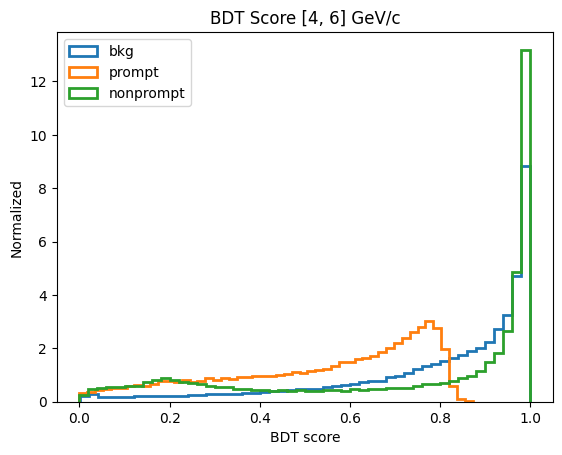

In [19]:
y_pred = best_xgb.predict(X_test)

val_accuracy = accuracy_score(y_test, y_pred)
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Print classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

scores= model.predict_proba(X_test)
plt.hist(scores[y_test==0 , 0],bins=50,density=True,histtype="step",linewidth=2,label="bkg")
plt.hist(scores[y_test==1 , 1],bins=50,density=True,histtype="step",linewidth=2,label="prompt")
plt.hist(scores[y_test==2 , 2],bins=50,density=True,histtype="step",linewidth=2,label="nonprompt")
plt.title(f"BDT Score [{pt_min}, {pt_max}] GeV/c")
plt.xlabel("BDT score")
plt.ylabel("Normalized")
plt.legend()
plt.show()


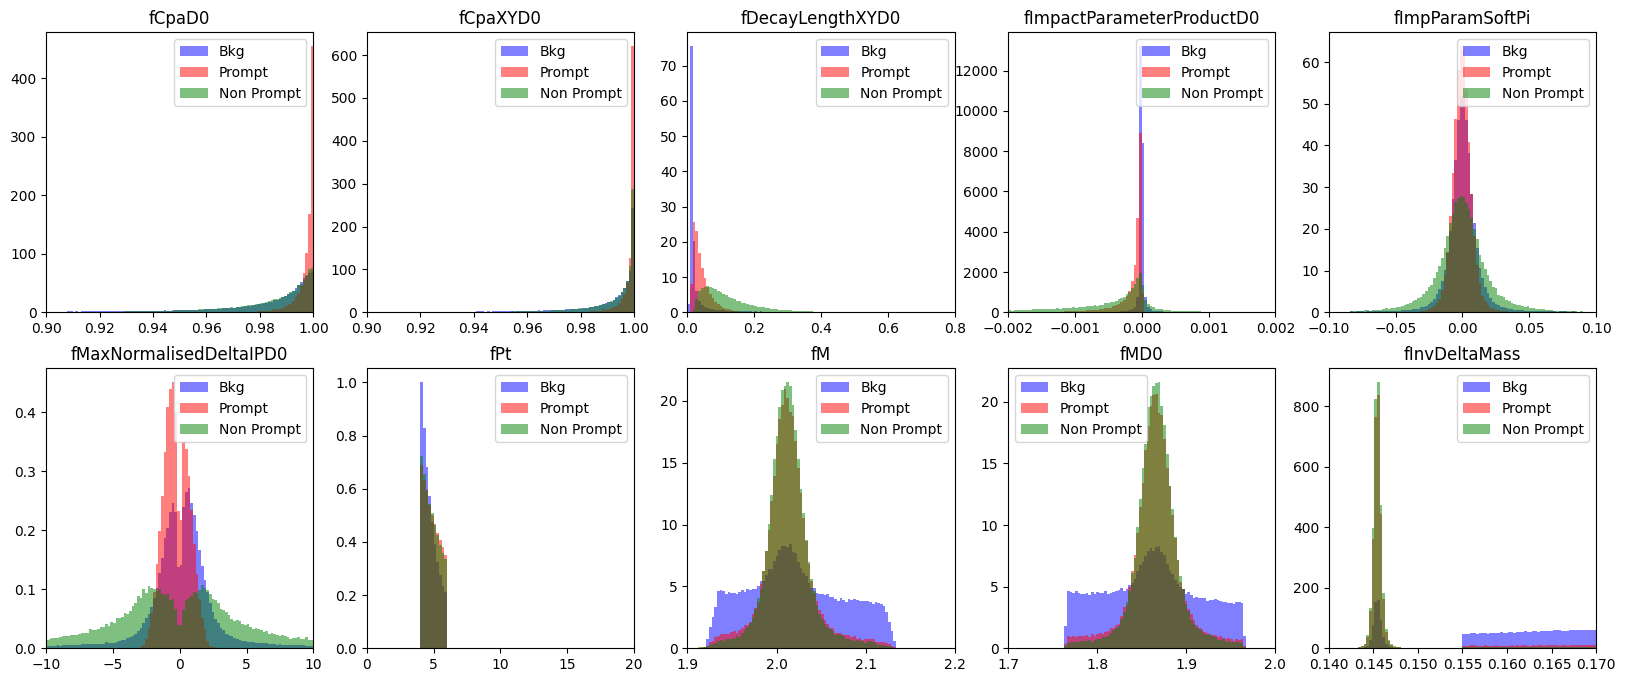

In [20]:

fig,axs=plt.subplots(2,5,figsize=(20,8))
axs=axs.flatten()
xlims = {
    "fCpaD0": (0.9, 1.0),
    "fCpaXYD0": (0.9, 1.0),
    "fDecayLengthXYD0": (0, 0.8),
    "fImpactParameterProductD0": (-0.002, 0.002),
    "fImpParamSoftPi" : (-0.1,0.1),
    "fMaxNormalisedDeltaIPD0" : (-10,10),
    "fPt": (0, 20),
    "fM": (1.9, 2.2),
    "fMD0": (1.7, 2.0),
    "fInvDeltaMass" : (0.14,0.17)
}
data=test
data=data.drop(['label'],axis=1)
data['label']=y_pred
for i in range(10):
    bins=np.linspace(xlims[para[i]][0],xlims[para[i]][1],101)
    #bins = common_bins(data[data['label']==0][para[i]],data[data['label']==1][para[i]],data[data['label']==2][para[i]])
    #bins=20
    axs[i].hist(data[data['label']==0][para[i]],bins=bins,alpha=0.5,color='blue',label='Bkg',density=True)
    axs[i].hist(data[data['label']==1][para[i]],bins=bins,alpha=0.5,color='red',label='Prompt',density=True)
    axs[i].hist(data[data['label']==2][para[i]],bins=bins,alpha=0.5,color='green',label="Non Prompt",density=True)
    axs[i].set_title(para[i])
    axs[i].set_xlim(xlims.get(para[i], None))
    axs[i].legend()
plt.show()

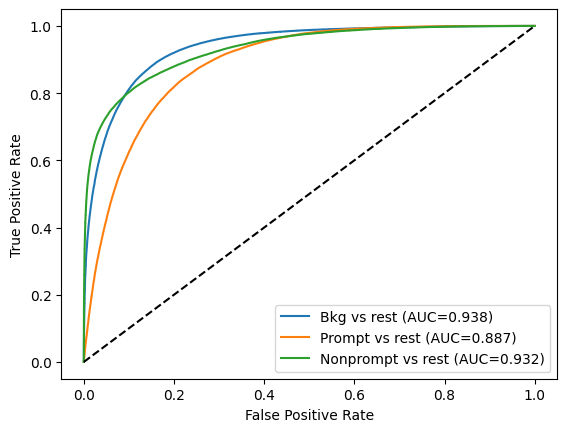

In [21]:
for k, name in zip([0,1,2], ["Bkg","Prompt","Nonprompt"]):
    y_true = (y_test == k).astype(int)
    y_score = scores[:, k]

    fpr, tpr, _ = roc_curve(y_true, y_score)
    plt.plot(fpr, tpr, label=f"{name} vs rest (AUC={auc(fpr,tpr):.3f})")

plt.plot([0,1],[0,1],"k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

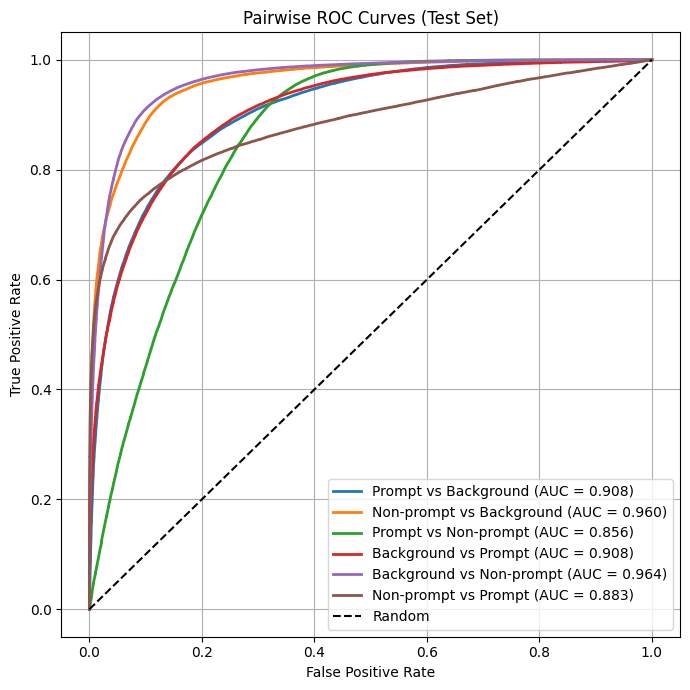

In [ ]:

y_proba=scores
pairwise_roc(y_test, y_proba, 1, 0, "Prompt vs Background")
pairwise_roc(y_test, y_proba, 2, 0, "Non-prompt vs Background")
pairwise_roc(y_test, y_proba, 1, 2, "Prompt vs Non-prompt")
pairwise_roc(y_test, y_proba, 0, 1, "Background vs Prompt")
pairwise_roc(y_test, y_proba, 0, 2, "Background vs Non-prompt")
pairwise_roc(y_test, y_proba, 2, 1, "Non-prompt vs Prompt")

plt.plot([0,1], [0,1], "k--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Pairwise ROC Curves (Test Set)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()